# Movie Recommendation Systems


In [67]:
import os
import json
import pickle
import numpy as np
import random
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
alt.data_transformers.disable_max_rows()
# alt.renderers.enable('notebook')

DataTransformerRegistry.enable('default')

I will use the
[MovieLens](https://grouplens.org/datasets/movielens/) dataset. Also,I will use the small version of the data set which you can download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). Please download it and put the unzipped directory in your `data` directory. The structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with the data. 


In [117]:
movie_ratings = pd.read_csv(os.path.join("data", "ml-latest-small", "ratings.csv"))
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [118]:
movie_n, movie_d = get_stats(movie_ratings, user_key="userId", item_key="movieId")

Number of ratings: 100836
The average rating: 3.501556983616962
Number of users: 610
Number of items: 9724
Fraction nonzero: 0.016999683055613623
Size of full X matrix (GB): 0.04745312


In [119]:
movie_X, user_mapper, movie_mapper, user_inverse_mapper, movie_inverse_mapper, user_ind, movie_ind = create_X(movie_ratings, movie_n, movie_d, user_key="userId", item_key="movieId")

In [120]:
toy_story_ind = 0
toy_story_vec = movie_X[toy_story_ind]

In [121]:
# to look up titles
movie_info = pd.read_csv(os.path.join("data", "ml-latest-small", "movies.csv"),index_col=0)
movie_info.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Let's use _Toy Story_ as our "query item", which is the first movie in the list (`movieId`=1). 


## I will find the following items:

>the movie with the most reviews

>the movie with the most total stars

>the movie with the lowest average stars

In [123]:
movie_info.iloc[np.argmax(movie_X.getnnz(axis=1)), :]

title          Forrest Gump (1994)
genres    Comedy|Drama|Romance|War
Name: 356, dtype: object

In [124]:
movie_info.iloc[np.argmax(movie_X.sum(axis=1)), :]

title     Shawshank Redemption, The (1994)
genres                         Crime|Drama
Name: 318, dtype: object

In [125]:
movie_info.iloc[np.argmin(np.squeeze(np.asarray(movie_X.sum(axis=1)))/movie_X.getnnz(axis=1)), :]

title     Screwed (2000)
genres            Comedy
Name: 3596, dtype: object

#### The movie with the lowest average stars is Screwed (2000).

In [3]:
# I will make a histogram of the number of ratings per user and the number of ratings per movie, and comment on the results.

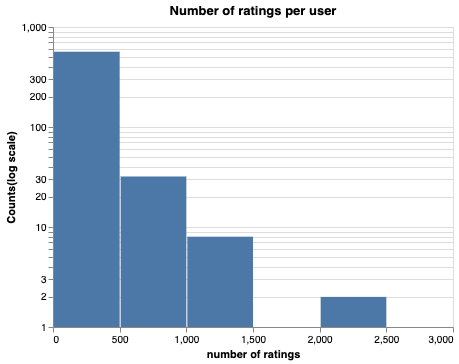

In [126]:
altair_hist(movie_X.getnnz(axis=0), "Number of ratings per user")

In [127]:
600/len(user_mapper)

0.9836065573770492

In [128]:
len(movie_mapper)

9724

Comment

98% users have 0-500 ratings, which means 98% columns have only 0-500 nonzero values(9724 row in total). It means that our matrix X is sparse.

Also, we can see 30 users have 500-1000 ratings, around 7 users have around 1000 to 1500 ratings,2 users have 2000 - 2500 ratings, 2 users have 80-100 ratings and another 2 users have 120-140 ratings. Thus, users who have more than 500 ratings is a small proportion.

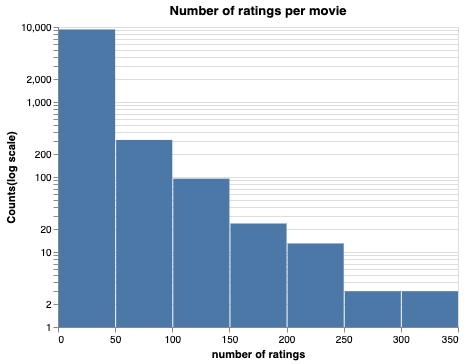

In [129]:
altair_hist(movie_X.getnnz(axis=1), "Number of ratings per movie")

In [130]:
9000/len(movie_mapper)

0.9255450431921021

In [131]:
len(user_mapper)

610

Comment

93% users have 0-50 ratings, which means 93% columns have only 0-50 nonzero values(610 row in total). It means that our matrix X is sparse.

Also, we can see 210 movies have 50-100 ratings,  100 movies have 100-150 ratings, 20 movies have 150-200 ratings, 10 movies have 200-250 ratings, 2 movies have 250-300 ratings and another 2 items have 300-350 ratings. Thus, movies who have more than 500 ratings is a small proportion.

In [1]:
# Find the 6 items most similar to Toy Story(1995). 

In [132]:
n_213 = NearestNeighbors(7, metric="euclidean")
n_213.fit(movie_X)
neighbors_euclidean = n_213.kneighbors(toy_story_vec, 7, return_distance=False)

In [135]:
for i in neighbors_euclidean.flatten():
    print(movie_info.loc[movie_inverse_mapper[i], :])
    print("_________________________________", "\n")

title                                Toy Story (1995)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 1, dtype: object
_________________________________ 

title                              Toy Story 2 (1999)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 3114, dtype: object
_________________________________ 

title            Mission: Impossible (1996)
genres    Action|Adventure|Mystery|Thriller
Name: 648, dtype: object
_________________________________ 

title     Independence Day (a.k.a. ID4) (1996)
genres        Action|Adventure|Sci-Fi|Thriller
Name: 780, dtype: object
_________________________________ 

title                    Bug's Life, A (1998)
genres    Adventure|Animation|Children|Comedy
Name: 2355, dtype: object
_________________________________ 

title       Nutty Professor, The (1996)
genres    Comedy|Fantasy|Romance|Sci-Fi
Name: 788, dtype: object
_________________________________ 

title     Willy Wonka & the Chocolate Factory (1971)
genres     

The 6 neighbors all have something in common with Toy Story. By looking at movie features, I found that except Mission and Independence Day, they are quite similar to the Toy Story.

In [2]:

# Using cosine similarity instead of Euclidean distance in NearestNeighbors

In [137]:
n_214 = NearestNeighbors(7, metric="cosine")
n_214.fit(movie_X)
neighbors_cos = n_214.kneighbors(toy_story_vec, 7, return_distance=False)

In [138]:
for i in neighbors_cos.flatten():
    print(movie_info.loc[movie_inverse_mapper[i], :])
    print("_________________________________", "\n")

title                                Toy Story (1995)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 1, dtype: object
_________________________________ 

title                              Toy Story 2 (1999)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 3114, dtype: object
_________________________________ 

title                 Jurassic Park (1993)
genres    Action|Adventure|Sci-Fi|Thriller
Name: 480, dtype: object
_________________________________ 

title     Independence Day (a.k.a. ID4) (1996)
genres        Action|Adventure|Sci-Fi|Thriller
Name: 780, dtype: object
_________________________________ 

title     Star Wars: Episode IV - A New Hope (1977)
genres                      Action|Adventure|Sci-Fi
Name: 260, dtype: object
_________________________________ 

title          Forrest Gump (1994)
genres    Comedy|Drama|Romance|War
Name: 356, dtype: object
_________________________________ 

title                               Lion King, The (1994)
genres 

Final Comments

It seems most neighbors are indeed similar to the Toy Story. The result is similar to the nearest neighbor by Euclidean distance.

I think this is because the dataset is smaller, so that the matrix is less sparse and it's much easier to find similar movies no matter it is by Euclidean distance or cosine similarity.